In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_csv('input/train_finalamend2.csv')

label = dataset.label

In [3]:
dataset['sp_trend'] = np.where(dataset.sp_Close.shift(-5) > dataset.sp_Close, 1, 0)
dataset['nd_trend'] = np.where(dataset.nd_Close.shift(-5) > dataset.nd_Close, 1, 0)
dataset['dj_trend'] = np.where(dataset.dj_Close.shift(-5) > dataset.dj_Close, 1, 0)
dataset['ph_trend'] = np.where(dataset.ph_Close.shift(-5) > dataset.ph_Close, 1, 0)

In [4]:
dataset = dataset.drop('label', axis=1)

dataset.info

<bound method DataFrame.info of             Date  sp_Open  sp_High   sp_Low  sp_Close   nd_Open   nd_High  \
0     2001-01-02  1320.28  1320.28  1276.05   1283.27   2474.16   2474.16   
1     2001-01-03  1283.27  1347.76  1274.62   1347.56   2254.56   2618.03   
2     2001-01-04  1347.56  1350.24  1329.14   1333.34   2593.96   2644.80   
3     2001-01-05  1333.34  1334.77  1294.95   1298.35   2573.11   2574.62   
4     2001-01-08  1298.35  1298.35  1276.29   1295.86   2388.72   2397.06   
...          ...      ...      ...      ...       ...       ...       ...   
4995  2021-12-23  4703.96  4740.74  4703.96   4725.79  15544.79  15697.98   
4996  2021-12-27  4733.99  4791.49  4733.99   4791.19  15696.83  15871.40   
4997  2021-12-28  4795.49  4807.02  4780.04   4786.35  15895.20  15901.47   
4998  2021-12-29  4788.64  4804.06  4778.08   4793.06  15794.92  15821.81   
4999  2021-12-31  4775.21  4786.83  4765.75   4766.18  15722.91  15777.43   

        nd_Low  nd_Close   dj_Open  ...    

In [5]:
training_set = dataset.iloc[:,1:].values
training_set.shape


(5000, 20)

In [6]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [7]:
training_set_scaled

array([[0.15572578, 0.15200584, 0.14812132, ..., 1.        , 0.        ,
        1.        ],
       [0.1467345 , 0.15868912, 0.14777366, ..., 0.        , 0.        ,
        0.        ],
       [0.16235323, 0.15929227, 0.16102838, ..., 1.        , 0.        ,
        1.        ],
       ...,
       [1.        , 1.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.99833585, 0.99928011, 0.99952349, ..., 0.        , 0.        ,
        0.        ],
       [0.99507314, 0.99508968, 0.99652586, ..., 0.        , 0.        ,
        0.        ]])

In [8]:
training_set_scaled = training_set_scaled.reshape(5000,1,20)
training_set_scaled.shape

(5000, 1, 20)

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(training_set_scaled, label, test_size=0.3, random_state=42)

In [10]:
x_train.shape

(3500, 1, 20)

In [11]:
def cw(label):
    c0, c1 = np.bincount(label)
    w0 = (1 / c0) * (len(label)) /4
    w1 = (1 / c1) * (len(label)) /4
    return {0: w0, 1: w1}

In [12]:
cw(label)

{0: 0.5577867023650156, 1: 0.45306270387821673}

In [13]:
# Import the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import keras

# Initialising the RNN
model = Sequential()

2022-02-22 13:51:07.753204: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
# Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 100, return_sequences = True, input_shape = (1, 20)))
# Adding the output layer
model.add(Dense(units = 100))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 100, return_sequences = True))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
# Adding the output layer
model.add(Dense(units = 50))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 10))
# Adding the output layer
model.add(Dense(units = 10))

# Adding the output layer
model.add(Dense(units = 1))

In [15]:
# Compiling
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])
model.summary()

# y不均勻 調整class weight
train_history = model.fit(x_train, y_train, epochs = 50, batch_size = 30, verbose=1, class_weight=cw(label))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 100)            48400     
                                                                 
 dense (Dense)               (None, 1, 100)            10100     
                                                                 
 lstm_1 (LSTM)               (None, 1, 100)            80400     
                                                                 
 lstm_2 (LSTM)               (None, 1, 50)             30200     
                                                                 
 dense_1 (Dense)             (None, 1, 50)             2550      
                                                                 
 lstm_3 (LSTM)               (None, 10)                2440      
                                                                 
 dense_2 (Dense)             (None, 10)                1

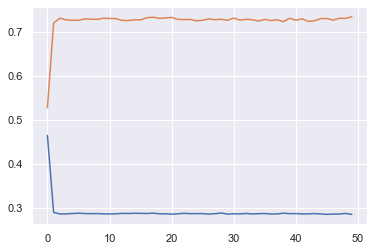

In [16]:
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['accuracy'])

In [17]:
testset = pd.read_csv('input/test20220218.csv')
testset


,Date,sp_Open,sp_High,sp_Low,sp_Close,nd_Open,nd_High,nd_Low,nd_Close,dj_Open,dj_High,dj_Low,dj_Close,ph_Open,ph_High,ph_Low,ph_Close
0,2021-01-04,3764.61,4394.60,4327.22,3700.65,2821.99,12958.72,12543.24,2783.21,30627.47,30674.28,29881.82,30223.89,2821.99,2872.20,2763.09,2783.21
1,2021-01-05,3698.02,4456.06,4373.81,3726.86,2783.18,12828.27,12665.65,2837.17,30204.25,30504.89,30141.78,30391.60,2783.18,2838.19,2782.62,2837.17
2,2021-01-06,3712.20,4489.55,4429.68,3748.14,2820.86,12909.63,12649.99,2827.96,30362.78,31022.65,30313.07,30829.40,2820.86,2884.61,2803.52,2827.96
3,2021-01-07,3764.71,4472.77,4429.28,3803.79,2873.66,13090.91,12867.34,2937.00,30901.18,31193.40,30897.86,31041.13,2873.66,2943.88,2873.17,2937.00
4,2021-01-08,3815.05,4426.22,4364.84,3824.68,2982.33,13208.09,13036.55,2936.47,31069.58,31140.67,30793.27,31097.97,2982.33,2994.07,2904.54,2936.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,2022-02-14,4412.61,3826.69,3783.60,4401.67,3376.12,13921.71,13664.76,3370.20,34694.50,34744.56,34304.28,34566.17,3376.12,3433.08,3324.55,3370.20
282,2022-02-15,4429.28,3811.55,3764.71,4471.07,3439.10,14142.49,13976.29,3554.45,34686.19,35047.79,34686.19,34988.84,3439.10,3559.77,3433.00,3554.45
283,2022-02-16,4455.75,3783.04,3705.34,4475.01,3511.21,14163.73,13931.99,3555.69,34951.83,35042.09,34642.64,34934.27,3511.21,3567.00,3480.87,3555.69
284,2022-02-17,4456.06,3737.83,3695.07,4380.26,3509.09,14020.82,13704.70,3422.60,34858.47,34858.47,34246.23,34312.03,3509.09,3512.04,3420.85,3422.60


In [37]:
testset['sp_trend'] = np.where(testset.sp_Close.shift(-5) > testset.sp_Close, 1, 0)
testset['nd_trend'] = np.where(testset.nd_Close.shift(-5) > testset.nd_Close, 1, 0)
testset['dj_trend'] = np.where(testset.dj_Close.shift(-5) > testset.dj_Close, 1, 0)
testset['ph_trend'] = np.where(testset.ph_Close.shift(-5) > testset.ph_Close, 1, 0)

In [20]:
dataset_total = pd.concat([dataset, testset], axis=0)
dataset_total = dataset_total.drop('Date', axis=1)
dataset_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5286 entries, 0 to 285
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sp_Open   5286 non-null   float64
 1   sp_High   5286 non-null   float64
 2   sp_Low    5286 non-null   float64
 3   sp_Close  5286 non-null   float64
 4   nd_Open   5286 non-null   float64
 5   nd_High   5286 non-null   float64
 6   nd_Low    5286 non-null   float64
 7   nd_Close  5286 non-null   float64
 8   dj_Open   5286 non-null   float64
 9   dj_High   5286 non-null   float64
 10  dj_Low    5286 non-null   float64
 11  dj_Close  5286 non-null   float64
 12  ph_Open   5286 non-null   float64
 13  ph_High   5286 non-null   float64
 14  ph_Low    5286 non-null   float64
 15  ph_Close  5286 non-null   float64
 16  sp_trend  5000 non-null   float64
 17  nd_trend  5000 non-null   float64
 18  dj_trend  5000 non-null   float64
 19  ph_trend  5000 non-null   float64
dtypes: float64(20)
memory usage: 86

In [40]:
result = model.predict(testset_scaled)

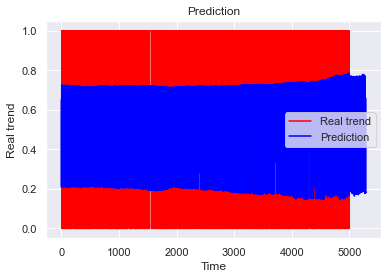

In [41]:
# Visualising the results
plt.plot(label, color = 'red', label = 'Real trend')  # 紅線表示真實股價
plt.plot(result, color = 'blue', label = 'Prediction')  # 藍線表示預測股價
plt.title('Prediction')
plt.xlabel('Time')
plt.ylabel('Real trend')
plt.legend()
plt.show()

In [42]:
result

array([[0.65149915],
       [0.20933326],
       [0.57337993],
       ...,
       [0.18310031],
       [0.18363892],
       [0.18300948]], dtype=float32)

In [43]:
result[-53:-1]

array([[0.77601695],
       [0.19478276],
       [0.40276554],
       [0.40196708],
       [0.19333065],
       [0.19237766],
       [0.74445415],
       [0.1904519 ],
       [0.77690154],
       [0.7748554 ],
       [0.7748942 ],
       [0.77627516],
       [0.7764446 ],
       [0.777336  ],
       [0.40079382],
       [0.7785396 ],
       [0.1924897 ],
       [0.19158939],
       [0.19147098],
       [0.19175561],
       [0.19138037],
       [0.7474372 ],
       [0.18849835],
       [0.670689  ],
       [0.18503828],
       [0.18703695],
       [0.18963112],
       [0.1912446 ],
       [0.18881671],
       [0.19072145],
       [0.1890294 ],
       [0.18578582],
       [0.38987508],
       [0.76958144],
       [0.7694146 ],
       [0.7705234 ],
       [0.7689779 ],
       [0.76645154],
       [0.17748094],
       [0.70593303],
       [0.7077972 ],
       [0.770147  ],
       [0.17802621],
       [0.17946665],
       [0.65640056],
       [0.18090759],
       [0.18243074],
       [0.658

In [25]:
# model.save('input/lstm_stock.h5')

In [44]:
testset.to_csv('input/testdata_forline.csv')